In [ ]:
import jax.numpy as np   
from jax import grad, jacfwd, jit, random, vmap
from jax.scipy.stats import multivariate_normal
from jax.tree_util import tree_map

from IPython.display import clear_output
import matplotlib.pyplot as plt
# from matplotlib import style
# style.use('dark_background')

# Affine transformation

Let us start with a good old Normal variable $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

In [ ]:
rng_key = random.PRNGKey(0)
z = random.normal(rng_key, (2,))
print(z)

[-0.78476596  0.85644484]


We define $\mathbf{x}$ as the affine transformation $\mathbf{x} = g^{-1}(\mathbf{z}) = A \mathbf{z} + \mathbf{b}$. The transformation is invertible and we have $\mathbf{z} = g(\mathbf{x}) = A^{-1} (\mathbf{x} - \mathbf{b})$.

In [ ]:
A = np.array([[0.75, -0.3],  
              [-0.7, 1.25]])
b = np.array([1.0, 0.5])

A_inv = np.linalg.inv(A)

def g_inv(z, A, b):
    return np.dot(A, z) + b

def g_fwd(x, A_inv, b):
    return np.dot(A_inv, x-b)

In [ ]:
# A simple sanity check
print("z =", z)
x = g_inv(z, A, b)
print("x = g_inv(z) =", x)
z = g_fwd(x, A_inv, b)
print("z = g_fwd(x) =", z)

z = [-0.78476596  0.85644484]
x = g_inv(z) = [0.15449208 2.1198921 ]
z = g_fwd(x) = [-0.78476596  0.8564447 ]


The transformation and its inverse are defined on a per-sample level, but can be easily vectorized using JAX's `vmap`:

In [ ]:
g_inv_vec = vmap(g_inv, in_axes=(0,None,None))
g_fwd_vec = vmap(g_fwd, in_axes=(0,None,None))

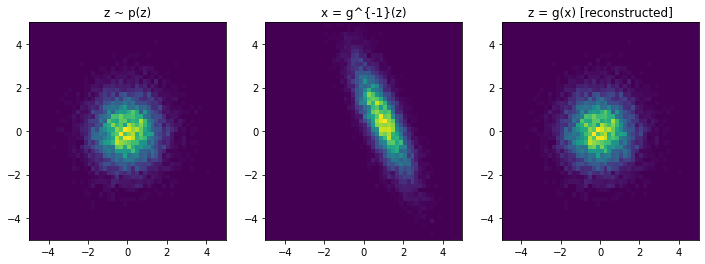

In [ ]:
# One more sanity check
rng_key = random.PRNGKey(1)
z = random.normal(rng_key, (10000, 2))

x     = g_inv_vec(z, A, b)
z_rec = g_fwd_vec(x, A_inv, b)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.hist2d(z[:, 0], z[:, 1], bins=50, range=[(-5,5), (-5,5)], density=True)
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)
ax1.set_title('z ~ p(z)')

ax2.hist2d(x[:, 0], x[:, 1], bins=50, range=[(-5,5), (-5,5)], density=True)
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.set_title('x = g^{-1}(z)')

ax3.hist2d(z_rec[:, 0], z_rec[:, 1], bins=50, range=[(-5,5), (-5,5)], density=True)
ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)
ax3.set_title('z = g(x) [reconstructed]')

plt.show()

The original $\mathbf{z}$ values are properly reconstructed from $\mathbf{x}$. So far so good!

For $\mathbf{x} = g^{-1}(\mathbf{z})$ with $\mathbf{z} \sim p(\mathbf{z})$, we have
$$p(\mathbf{x}) = p(g(\mathbf{x})) \left| \text{det} J_{g(\mathbf{x})} \right|,$$
where the Jacobian $J_{g(\mathbf{x})} = \frac{\partial g(\mathbf{x})}{\partial \mathbf{x}}$.

Taking the logarithm of both sides we then get
$$\log p(\mathbf{x}) = \log p(g(\mathbf{x})) + \log\left| \text{det} J_{g(\mathbf{x})} \right|$$

In [ ]:
# Let's evaluate log p(x) using the change of variables formula
z = random.normal(rng_key, (2,))
x = g_inv(z, A, b)

mu_z = np.zeros(2)
cov_z = np.eye(2)

logp_z = multivariate_normal.logpdf(z, mean=mu_z, cov=cov_z)

# Compute the Jacobian of g using automatic differentiation
J = jacfwd(g_fwd) # this return a callable function!

# Compute the log-likelihood of x using the change of variables formula
logp_x = multivariate_normal.logpdf(g_fwd(x, A_inv, b), mean=mu_z, cov=cov_z) + \
         np.log(np.abs(np.linalg.det(J(x, A_inv, b))))

print("log p(z) =", logp_z)
print("log p(x) =", logp_x)

log p(z) = -4.292217
log p(x) = -3.9740756


Since we consider an affine transformation of the normal $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, we also know that 
$$p(\mathbf{x}) = \mathcal{N}(g^{-1}(\mu), A \Sigma A^T)).$$

In [ ]:
# Yet another sanity check
# Confirm that the \log p(x) we compute above agrees with what we expect
print("log p(x) =", multivariate_normal.logpdf(x, 
                                               mean=g_inv(mu_z, A, b), 
                                               cov=A @ cov_z @ A.T))

log p(x) = -3.974076


Hence, our expression for the density based on the change of variables theorem seems to hold!

Again, we can use `vmap` to vectorize the evaluation of the density over an entire batch of samples:

In [ ]:
J_vec = vmap(J, in_axes=(0,None,None)) # returns a callable function!
det_vec = vmap(np.linalg.det) # returns a callable function!

# Generate a batch of samples
z = random.normal(rng_key, (5, 2))
x = g_inv_vec(z, A, b)

# One more sanity check..

# \log p(x) from the change of variabled formula
print("log p(x) =", multivariate_normal.logpdf(g_fwd_vec(x, A_inv, b), 
                                               mean=np.zeros(2), 
                                               cov=np.eye(2)) + 
                    np.log(np.abs(det_vec(J_vec(x, A_inv, b)))))
# \log p(x) from our analytical calculation
print("log p(x) =", multivariate_normal.logpdf(x, 
                                               mean=g_inv(mu_z, A, b), 
                                               cov= np.dot(A, np.dot(cov_z,A.T))))

log p(x) = [-1.877141  -2.1949906 -1.66791   -3.400479  -1.5975088]
log p(x) = [-1.877141  -2.1949906 -1.66791   -3.4004796 -1.5975088]


The results agree as expected!

Ok, seems like we're ready to play around training a normalizing flow :)

# Parameter estimation via Maximum Likelihood Estimation (MLE)

Given observations $\mathbf{x}$ and assuming the affine transformation $\mathbf{z} = g(\mathbf{x}) = A^{-1} (\mathbf{x} - \mathbf{b})$, the parameters $A^{-1}$ and $\mathbf{b}$ can be estimated by maximizing the likelihood $p(\mathbf{x} | A^{-1}, \mathbf{b})$.

Let us start with some training data $\mathbf{x} \sim p(\mathbf{x})$.

In [ ]:
# Generate some reference observations for x
z_train = random.normal(rng_key, (10000, 2))
x_train = g_inv_vec(z_train, A, b)

Given these observations we ask the question: can we identify the parameters $A^{-1}$ and $\mathbf{b}$ that generate the observed data?

Let's try to estimate them via MLE.

To this end, we need to find $A^{-1}$ and $\mathbf{b}$ that maximize the likelihood of our observations, $p(x|A^{-1}, \mathbf{b})$. Or, alternatively, minimize the negative log-likelihood  $-\log p(\mathbf{x} | A^{-1}, \mathbf{b})$.

In general, $\log p(\mathbf{x} | A^{-1}, \mathbf{b})$ will be intractable to compute directly, but we can use the change of variables formula to evaluate it in terms of $\log p(\mathbf{z})$ and the log-determinant of the Jacobian of $g(\mathbf{x})$.

This is how we will construct our loss function, which will allow us to determine the optimal $A^{-1}$ and $\mathbf{b}$. 

The `jit` directive is used for just-in-time compilation with XLA. This can optimize the function call and can oftentimes yield >10x speed-ups in compute time! 

In [ ]:
@jit
def loss(params, batch):
    A_inv, b = params
    return -np.mean(multivariate_normal.logpdf(g_fwd_vec(batch, A_inv, b), 
                                               mean=np.zeros(2), 
                                               cov=np.eye(2)) + 
                    np.log(np.abs(det_vec(J_vec(batch, A_inv, b)))))

Since JAX supports automatic differentiation, we can readily obtain its gradient with respect to its 1st ($A^{-1}$) and 2nd ($\mathbf{b}$) argument using `grad`:

In [ ]:
grad_loss = grad(loss)

Hence making it immediate to estimate $A^{-1}$ and $\mathbf{b}$ using gradient descent.

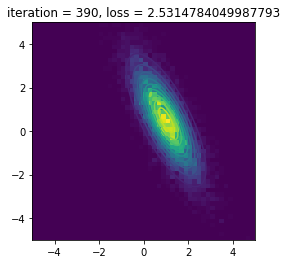

In [ ]:
# Initial guess for the unkown parameters
A_inv_est = np.eye(2) + random.normal(rng_key, (2, 2)) * 0.01
b_est = random.normal(rng_key, (2,)) * 0.01

# Define a learning rate parameter
lr = 0.01

# Define the gradient descent step
def step(params, batch):
    grads = grad_loss(params, batch)
    params = tree_map(lambda x, g: x - lr*g, params, grads)
    return params

# Initial parameters and training data batch
params = A_inv_est, b_est
batch = x_train

for i in range(400):
    params = step(params, batch)
    
    # Show progress
    if i % 10 == 0:
        clear_output(wait=True)
        A_inv_est, b_est = params

        plt.figure(figsize=(4, 4))
        plt.title("iteration = {}, loss = {}".format(i, loss(params, batch)))
        
        plt.hist2d(batch[:, 0], batch[:, 1], bins=50, range=[(-5,5), (-5,5)], density=True)
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)

        x = np.arange(-5.0, 5.0, 0.05)
        y = np.arange(-5.0, 5.0, 0.05)
        X, Y = np.meshgrid(x, y)
        shape = X.shape
        grid = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
        Z = np.exp(multivariate_normal.logpdf(g_fwd_vec(grid, A_inv_est, b_est), 
                                              mean=np.zeros(2), 
                                              cov=np.eye(2)) + np.log(np.abs(det_vec(J_vec(grid, A_inv_est, b_est)))))
        Z = Z.reshape(shape)
        CS = plt.contour(X, Y, Z, levels=10, lw=2)

        plt.show()

Of course, in this case, fitting the parameters of an affine transformation of a Normal distribution by expressing the data likelihood through the change of variables theorem is clearly an overkill. 

However, the same recipe holds for any invertible transformation $\mathbf{z} = g(\mathbf{x})$. In particular, parameterizing $g$ with an invertible neural network will result in a [Normalizing Flow](https://arxiv.org/abs/1912.02762).